In [1]:
from __future__ import print_function
import os
import pickle

import pickle
from netCDF4 import Dataset

import numpy as np
import time
import datetime

from sklearn import svm, datasets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

import scipy.io
import scipy.integrate
from astropy.convolution import convolve, Box1DKernel
from spacepy import pycdf

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path as mpath

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pathlib import Path

%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_rows = 90

np.set_printoptions(threshold=np.nan)

plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
plt.rc('text', usetex=True)

###############
## COMPUTER ##
###############

laptop = False

In [ ]:
def boxcar_width(x):
    return (np.ceil(x) // 2 * 2 + 1).astype(int)

In [ ]:
# only use the .wind.nc for AHATS, not mom.nc (moment info)
# only use the CASES99/profiles/prof915h not the prof915l

# AHATS and CASES99 surface_met has temp and RH at 2 m, winds at 10 m. 1 min intervals

# AHATS wind profiles are 3d wind vector at 168.,  266.,  364.,  462.,  560.,  658., ... 4970 m heights. 30 min intervals
# AHATS virtual temp profiles are at 120.,  180.,  240.,  300.,  360.,  420.,  480.,  540., ... 1260 m heights. 30 min intervals

# CASES99 profiles are 3d wind vector at 137.,  193.,  249.,  305.,  361.,  417.,  473.,  529.,  585., 641., ... 3106 m heights. 30 min intervals

# MainHighRateCASES99 is a 55m tower at 20Hz, has virtual temp at 1.5m and 10m 
# has 3d wind at 1.5, 5, 10, 20, 30, 40, 50, 55 m

# MainLowRateCASES99 is same as high rate 55m tower but temporal of 1 second, and only has temp at 2, 15, 25, 35, 45, 55m 
# has 3d wind at 15, 25, 35, 45 m

# 10mTowerCASES99, see soler.readme
# this data is in a gully, it has strong katabatic forcing, don't want to use

# AHAT surface sample file
# /media/synology2/WANDS/NCAR/AHATS/surface/surface_met.20080421.165253.nc

# AHAT profile sample file
# /media/synology2/WANDS/NCAR/AHATS/profiles/nima.20080604.winds.nc

# CASES99 surface sample file
# /media/synology2/WANDS/NCAR/EldoradoCASES99/surface/surface_met.990930.071703.cdf

# CASES99 profile sample file
# /media/synology2/WANDS/NCAR/EldoradoCASES99/profiles/prof915h.990930.165100.cdf #naming prof915[l].[YYMMDD].[HHMMSS].cdf

# MainHighRateCASES99 profile sample file
# /media/synology2/WANDS/NCAR/MainHighRateCASES99/cases_tower_hr_19991011_00.nc

# MainLowRateCASES99 profile sample file
# /media/synology2/WANDS/NCAR/MainLowRateCASES99/cases_tower_lr_19991011_00.nc

cdfH = Dataset('/media/synology2/WANDS/NCAR/MainHighRateCASES99/cases_tower_hr_19991011_00.nc')
cdfL = Dataset('/media/synology2/WANDS/NCAR/MainLowRateCASES99/cases_tower_lr_19991011_00.nc')

# Load the RGB arrays
np.shape(cdfH.variables['tc_1_5m'][:])

# RH 15m has some real issues, lots of masked data, going to only use rh_5m unfortunately.

In [ ]:
###############
## GRAB 20HZ DATA ON TIME U,V (10m, 50m), P,VT (10m, 1.5m) ##
###############

days = range(6,30+1)
hours = [0,12]

tdel = 18
 
VTL_f = []
VTH_f = []
P_f  = []
UL_f  = []
VL_f  = []
UH_f  = []
VH_f  = []
T_f   = []

for i in days:
    for j in hours:
        cdfH = Dataset('/media/synology2/WANDS/NCAR/MainHighRateCASES99/cases_tower_hr_199910%02d_%02d.nc'%(i,j))

        vtls = cdfH.variables['tc_1_5m'][:]
        vths = cdfH.variables['tc_10m'][:]
        ps   = cdfH.variables['pp_1_5m'][:]
        uls  = cdfH.variables['u_10m'][:]
        vls  = cdfH.variables['v_10m'][:]
        uhs  = cdfH.variables['u_55m'][:]
        vhs  = cdfH.variables['v_55m'][:]
        ts   = cdfH.variables['time'][:]

        t0   = cdfH.variables['base_time'][:]
        tdel_steps = int(tdel/(ts[1]-ts[0]))
        tLen_steps = int(ts[-1]/tdel)
        
        vtlb  = np.empty([tLen_steps])
        vthb  = np.empty([tLen_steps])
        pb    = np.empty([tLen_steps])
        ulb   = np.empty([tLen_steps])
        vlb   = np.empty([tLen_steps])
        uhb   = np.empty([tLen_steps])
        vhb   = np.empty([tLen_steps])
        tb    = np.empty([tLen_steps])

        for k in np.arange(0,np.shape(tb)[0]):
            # get 20 sec data (mean the high res to that, reduce grid)
            vtl_step = vtls[tdel_steps*k:tdel_steps*(k+1)]
            vth_step = vths[tdel_steps*k:tdel_steps*(k+1)]       
            p_step   = ps[tdel_steps*k:tdel_steps*(k+1)]
            ul_step  = uls[tdel_steps*k:tdel_steps*(k+1)]
            vl_step  = vls[tdel_steps*k:tdel_steps*(k+1)]
            uh_step  = uhs[tdel_steps*k:tdel_steps*(k+1)]
            vh_step  = vhs[tdel_steps*k:tdel_steps*(k+1)]
            t_step   = ts[tdel_steps*k:tdel_steps*(k+1)]
            
            vtlb[k]  = np.mean(vtl_step)
            vthb[k]  = np.mean(vth_step)
            pb[k]    = np.mean(p_step)
            ulb[k]   = np.mean(ul_step)
            vlb[k]   = np.mean(vl_step)
            uhb[k]   = np.mean(uh_step)
            vhb[k]   = np.mean(vh_step)
            tb[k]    = np.mean(t_step)
            
        tb = tb + t0
        
        VTL_f.append(vtlb)
        VTH_f.append(vthb)
        P_f.append(pb)
        UL_f.append(ulb)
        VL_f.append(vlb)
        UH_f.append(uhb)
        VH_f.append(vhb)
        T_f.append(tb)
        
        print('cases_tower_hr_199910%02d_%02d.nc'%(i,j))

In [ ]:
# i = 28
# j = 0

# tdel = 18

# cdfL = Dataset('/media/synology2/WANDS/NCAR/MainLowRateCASES99/cases_tower_lr_199910%02d_%02d.nc'%(i,j))

# ts  = cdfL.variables['time'][:]

# hls  = cdfL.variables['RH_5m'][:]
# #         hhs  = cdfL.variables['RH_15m'][:]

# t0   = cdfL.variables['base_time'][:]
# tdel_steps = int(tdel/(ts[1]-ts[0]))
# tLen_steps = int(ts[-1]/tdel)

# hlb   = np.empty([tLen_steps])
# #         hhb   = np.empty([tLen_steps])
# tb   = np.empty([tLen_steps])


# for k in np.arange(0,np.shape(tb)[0]):
#     hl_step  = hls[tdel_steps*k:tdel_steps*(k+1)]
# #             hh_step  = hhs[tdel_steps*k:tdel_steps*(k+1)]
#     t_step   = ts[tdel_steps*k:tdel_steps*(k+1)]

#     hlb[k]   = np.mean(hl_step)
# #             hhb[k]   = np.mean(hh_step)
#     tb[k]    = np.mean(t_step)

# print('cases_tower_hr_199910%02d_%02d.nc'%(i,j))

In [ ]:

# plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
# plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
# plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

# S = 0.1
# LW = 0.8
# fs = 12

# fig = plt.gcf()

# ax1 = plt.subplot(111)

# s = ax1.scatter(ts, hls, lw=LW, c='r', s=S)

# s = ax1.scatter(tb, hlb, lw=LW, c='b', s=S)

# ax1.set_xlabel('$t$ (s)', fontsize=fs)
# ax1.set_ylabel('$h_{10}$ ($\%$)', fontsize=fs)

# plt.xticks(fontsize=fs)
# plt.yticks(fontsize=fs)

# fig.set_size_inches(12, 8, forward=True)
# # %cd /home/andrew/Documents/
# # plt.savefig('some_name75.pdf', bbox_inches='tight')

In [ ]:
###############
## GRAB 1HZ DATA ON H (5m, 15m) ##
###############

days = range(6,30+1)
hours = [0,12]

tdel = 18

HL_s  = []
HH_s  = []
T_s  = []

for i in days:
    for j in hours:
        cdfL = Dataset('/media/synology2/WANDS/NCAR/MainLowRateCASES99/cases_tower_lr_199910%02d_%02d.nc'%(i,j))
        
        ts  = cdfL.variables['time'][:]
        
        hls  = cdfL.variables['RH_5m'][:]
        hhs  = cdfL.variables['RH_15m'][:]

        t0   = cdfL.variables['base_time'][:]
        tdel_steps = int(tdel/(ts[1]-ts[0]))
        tLen_steps = int(ts[-1]/tdel)

        hlb   = np.empty([tLen_steps])
        hhb   = np.empty([tLen_steps])
        tb   = np.empty([tLen_steps])


        for k in np.arange(0,np.shape(tb)[0]):
            hl_step  = hls[tdel_steps*k:tdel_steps*(k+1)]
            hh_step  = hhs[tdel_steps*k:tdel_steps*(k+1)]
            t_step   = ts[tdel_steps*k:tdel_steps*(k+1)]
            
            hlb[k]   = np.mean(hl_step)
            hhb[k]   = np.mean(hh_step)
            tb[k]    = np.mean(t_step)
            
        tb = tb + t0
        
        HL_s.append(hlb)
        HH_s.append(hhb)
        T_s.append(tb)
        
        print('cases_tower_hr_199910%02d_%02d.nc'%(i,j))

In [ ]:
# make nan array same length as T_s
# make closest T_f index to each T_s index lists, if times are closer than half a timestep
# replace nan entries in first list by the actual values from _f into the appropriate _s index by second array

T_s   = np.concatenate(T_s)
T_f   = np.concatenate(T_f)

T_s_matchindices = []
T_f_matchindices = []

for i in np.arange(0,np.shape(T_s)[0]):
    temp = np.abs(T_f-T_s[i])
    
    if np.nanmin(temp)<=tdel/2:
        T_s_matchindices.append(i)
        T_f_matchindices.append(np.argmin(temp))

In [ ]:
VTL_f = np.concatenate(VTL_f)
VTH_f = np.concatenate(VTH_f)
P_f   = np.concatenate(P_f)
UL_f  = np.concatenate(UL_f)
VL_f  = np.concatenate(VL_f)
UH_f  = np.concatenate(UH_f)
VH_f  = np.concatenate(VH_f)


VTL_s = np.empty(np.shape(T_s)[0])
VTL_s[:] = np.nan
VTL_s[T_s_matchindices] = VTL_f[T_f_matchindices]

VTH_s = np.empty(np.shape(T_s)[0])
VTH_s[:] = np.nan
VTH_s[T_s_matchindices] = VTH_f[T_f_matchindices]

P_s = np.empty(np.shape(T_s)[0])
P_s[:] = np.nan
P_s[T_s_matchindices] = P_f[T_f_matchindices]

HL_s  = np.concatenate(HL_s)
HH_s  = np.concatenate(HH_s)


In [ ]:
###############
## STRUCTURE FAST DATA, GET RID OF NANS ##
###############

VTL_f[np.isinf(VTL_f)] = np.nan
VTH_f[np.isinf(VTH_f)] = np.nan
P_f[np.isinf(P_f)]     = np.nan
UL_f[np.isinf(UL_f)]   = np.nan
VL_f[np.isinf(VL_f)]   = np.nan
UH_f[np.isinf(UH_f)]   = np.nan
VH_f[np.isinf(VH_f)]   = np.nan
T_f[np.isinf(T_f)]     = np.nan

bad_index = np.append(np.argwhere(np.isnan(VTL_f)),np.argwhere(np.isnan(VTH_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(P_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(UL_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(VL_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(UH_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(VH_f)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(T_f)))

VTL_f = np.delete(VTL_f,bad_index)
VTH_f = np.delete(VTH_f,bad_index)
P_f   = np.delete(P_f,bad_index)
UL_f  = np.delete(UL_f,bad_index)
VL_f  = np.delete(VL_f,bad_index)
UH_f  = np.delete(UH_f,bad_index)
VH_f  = np.delete(VH_f,bad_index)
T_f   = np.delete(T_f,bad_index)

In [ ]:
###############
## STRUCTURE SLOW DATA, GET RID OF NANS ##
###############

VTL_s[np.isinf(VTL_s)] = np.nan
VTH_s[np.isinf(VTH_s)] = np.nan
P_s[np.isinf(P_s)]     = np.nan
HL_s[np.isinf(HL_s)]   = np.nan
HH_s[np.isinf(HH_s)]   = np.nan
T_s[np.isinf(T_s)]     = np.nan

bad_index = np.append(np.argwhere(np.isnan(VTL_s)),np.argwhere(np.isnan(VTH_s)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(P_s)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(HL_s)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(HH_s)))
bad_index = np.append(bad_index,np.argwhere(np.isnan(T_s)))

VTL_s = np.delete(VTL_s,bad_index)
VTH_s = np.delete(VTH_s,bad_index)
P_s   = np.delete(P_s,bad_index)
HL_s  = np.delete(HL_s,bad_index)
HH_s  = np.delete(HH_s,bad_index)
T_s   = np.delete(T_s,bad_index)

In [ ]:
## PROBLEM HERE:::
np.unique(T_f_matchindices)

In [ ]:
###############
## FIND THE PVT GRADIENT FROM 1.5 TO 10m, FIND WIND SPEED, FIND THE AVERAGE H BETWEEN 5 AND 15m ##
###############

c_2_K = 273.15
p_ref = 1000.0       #mbar refence pressure for potential temp

rv = 0.0023311539671456807

PVTL_f = (VTL_f+c_2_K)*(p_ref/P_f)**(0.2854*(1-0.24*rv))
PVTH_f = (VTH_f+c_2_K)*(p_ref/P_f)**(0.2854*(1-0.24*rv))

DTDZ_f = (PVTH_f-PVTL_f)/(10-1.5)
   
WSL_f = (UL_f**2+VL_f**2)**0.5
WSH_f = (UH_f**2+VH_f**2)**0.5


PVTL_s = (VTL_s+c_2_K)*(p_ref/P_s)**(0.2854*(1-0.24*rv))
PVTH_s = (VTH_s+c_2_K)*(p_ref/P_s)**(0.2854*(1-0.24*rv))

DTDZ_s = (PVTH_s-PVTL_s)/(10-1.5)

H_s = (HL_s+HH_s)/2
# H_s = HL_s

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('DTDZ_f.pkl', 'wb') as f:
    pickle.dump(DTDZ_f, f)
with open('WSL_f.pkl', 'wb') as f:
    pickle.dump(WSL_f, f)
with open('WSH_f.pkl', 'wb') as f:
    pickle.dump(WSH_f, f)      
with open('T_f.pkl', 'wb') as f:
    pickle.dump(T_f, f)

with open('DTDZ_s.pkl', 'wb') as f:
    pickle.dump(DTDZ_s, f)
with open('H_s.pkl', 'wb') as f:
    pickle.dump(H_s, f)
with open('T_s.pkl', 'wb') as f:
    pickle.dump(T_s, f)

In [ ]:
###############
## MAKE THE DAILY TIME LOOP AND THE SMOOTHING TIMESCALE - FAST ##
###############

smooth_timescale = 1*60*60 #1 hour
traj_smoothgl = boxcar_width(smooth_timescale*np.shape(T_f)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

TD_f = (T_f-T_f[0])/60/60/24

temp1 = TD_f%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

In [ ]:
###############
## SMOOTH THE DATA TO 1HOURLY DAILY CYCLE - FAST##
###############

temp2 = WSL_f[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

x2  = WSL_f
x2m = temp3
x225 = temp41
x275 = temp42

temp2 = WSH_f[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

x1  = WSH_f
x1m = temp3
x125 = temp41
x175 = temp42

temp2 = DTDZ_f[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

y_f  = DTDZ_f
ym_f = temp3
y25_f = temp41
y75_f = temp42

In [ ]:
###############
## MAKE THE DAILY TIME LOOP AND THE SMOOTHING TIMESCALE - SLOW ##
###############

smooth_timescale = 1*60*60 #1 hour
traj_smoothgl = boxcar_width(smooth_timescale*np.shape(T_s)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

TD_s = (T_s-T_s[0])/60/60/24

temp1 = TD_s%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

In [ ]:
###############
## SMOOTH THE DATA TO 1HOURLY DAILY CYCLE - FAST##
###############

temp2 = H_s[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

h  = H_s
hm = temp3
h25 = temp41
h75 = temp42

temp2 = DTDZ_s[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

y_s  = DTDZ_s
ym_s = temp3
y25_s = temp41
y75_s = temp42

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('y_f.pkl', 'wb') as f:
    pickle.dump(y_f, f)
with open('ym_f.pkl', 'wb') as f:
    pickle.dump(ym_f, f)
with open('y25_f.pkl', 'wb') as f:
    pickle.dump(y25_f, f)
with open('y75_f.pkl', 'wb') as f:
    pickle.dump(y75_f, f)
    
with open('x1.pkl', 'wb') as f:
    pickle.dump(x1, f)
with open('x1m.pkl', 'wb') as f:
    pickle.dump(x1m, f)
with open('x125.pkl', 'wb') as f:
    pickle.dump(x125, f)
with open('x175.pkl', 'wb') as f:
    pickle.dump(x175, f)

with open('x2.pkl', 'wb') as f:
    pickle.dump(x2, f)
with open('x2m.pkl', 'wb') as f:
    pickle.dump(x2m, f)
with open('x225.pkl', 'wb') as f:
    pickle.dump(x225, f)
with open('x275.pkl', 'wb') as f:
    pickle.dump(x275, f)
    
    
    
    
with open('y_s.pkl', 'wb') as f:
    pickle.dump(y_s, f)
with open('ym_s.pkl', 'wb') as f:
    pickle.dump(ym_s, f)
with open('y25_s.pkl', 'wb') as f:
    pickle.dump(y25_s, f)
with open('y75_s.pkl', 'wb') as f:
    pickle.dump(y75_s, f)
    
with open('h.pkl', 'wb') as f:
    pickle.dump(h, f)
with open('hm.pkl', 'wb') as f:
    pickle.dump(hm, f)
with open('h25.pkl', 'wb') as f:
    pickle.dump(h25, f)
with open('h75.pkl', 'wb') as f:
    pickle.dump(h75, f)

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('y_f.pkl', 'rb') as f:
    y_f = pickle.load(f)
with open('ym_f.pkl', 'rb') as f:
    ym_f = pickle.load(f)
with open('y25_f.pkl', 'rb') as f:
    y25_f = pickle.load(f)
with open('y75_f.pkl', 'rb') as f:
    y75_f = pickle.load(f)
    
with open('x1.pkl', 'rb') as f:
    x1 = pickle.load(f)
with open('x1m.pkl', 'rb') as f:
    x1m = pickle.load(f)
with open('x125.pkl', 'rb') as f:
    x125 = pickle.load(f)
with open('x175.pkl', 'rb') as f:
    x175 = pickle.load(f)

with open('x2.pkl', 'rb') as f:
    x2 = pickle.load(f)
with open('x2m.pkl', 'rb') as f:
    x2m = pickle.load(f)
with open('x225.pkl', 'rb') as f:
    x225 = pickle.load(f)
with open('x275.pkl', 'rb') as f:
    x275 = pickle.load(f)

    
    
with open('y_s.pkl', 'rb') as f:
    y_s = pickle.load(f)
with open('ym_s.pkl', 'rb') as f:
    ym_s = pickle.load(f)
with open('y25_s.pkl', 'rb') as f:
    y25_s = pickle.load(f)
with open('y75_s.pkl', 'rb') as f:
    y75_s = pickle.load(f)
    
with open('h.pkl', 'rb') as f:
    h = pickle.load(f)
with open('hm.pkl', 'rb') as f:
    hm = pickle.load(f)
with open('h25.pkl', 'rb') as f:
    h25 = pickle.load(f)
with open('h75.pkl', 'rb') as f:
    h75 = pickle.load(f)

In [ ]:
###############
## FIND THE DAILY LOOP OF THE SCALE FROM THE LAW OF THE WALL ##
###############

# z0xxx = np.median(z0_c[~np.isnan(z0_c)])
z0xxx = 0.1
xx1 = x2m*np.log(50/z0xxx)/np.log(10/z0xxx)

XX1 = x1/(x2*np.log(50/z0xxx)/np.log(10/z0xxx))

smooth_timescale = 1*60*60 #1 hour
traj_smoothgl = boxcar_width(smooth_timescale*np.shape(T_f)[0]/(24*60*60)) #smooth_timescale is the timescale in seconds
boxgl = int(traj_smoothgl/2)

temp1 = TD_f%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt = tgl_traj

temp2 = XX1[indt]
temp3 = np.empty([np.shape(temp2)[0],1])
temp41 = np.empty([np.shape(temp2)[0],1])
temp42 = np.empty([np.shape(temp2)[0],1])
for i in np.arange(0,np.shape(temp1)[0]):
    hhs = i
    hhl = boxgl
    hhg = []
    for j in np.arange(hhs-hhl,hhs+hhl+1):
        if j>=np.shape(temp2)[0]:
            j = j - np.shape(temp2)[0]
        hhg.append(temp2[j])
    temp3[i] = np.mean(hhg)
    temp41[i] = np.percentile(hhg,25)
    temp42[i] = np.percentile(hhg,75)
temp3 = np.squeeze(temp3)
temp41 = np.squeeze(temp41)
temp42 = np.squeeze(temp42)

XX1m = temp3
XX125 = temp41
XX175 = temp42

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('XX1.pkl', 'wb') as f:
    pickle.dump(XX1, f)
with open('XX1m.pkl', 'wb') as f:
    pickle.dump(XX1m, f)
with open('XX125.pkl', 'wb') as f:
    pickle.dump(XX125, f)
with open('XX175.pkl', 'wb') as f:
    pickle.dump(XX175, f)

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('XX1.pkl', 'rb') as f:
    XX1 = pickle.load(f)
with open('XX1m.pkl', 'rb') as f:
    XX1m = pickle.load(f)
with open('XX125.pkl', 'rb') as f:
    XX125 = pickle.load(f)
with open('XX175.pkl', 'rb') as f:
    XX175 = pickle.load(f)

In [ ]:
###############
## CREATE THE INTERQUARTILE RANGE UNION SHAPE - FAST ##
###############

temp1 = TD_f%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt_f = tgl_traj

import shapely.geometry as sg
import shapely.ops as so

r1d = []
for i in range(0,np.shape(tt_f)[0]):
    r1d.append(sg.box(x125[i],y25_f[i],x175[i],y75_f[i]))
new_shape1d = so.cascaded_union(r1d)
xo1d, yo1d = new_shape1d.exterior.xy

r2d = []
for i in range(0,np.shape(tt_f)[0]):
    r2d.append(sg.box(x225[i],y25_f[i],x275[i],y75_f[i]))
new_shape2d = so.cascaded_union(r2d)
xo2d, yo2d = new_shape2d.exterior.xy

r5d = []
for i in range(0,np.shape(tt_f)[0]):
    r5d.append(sg.box(XX125[i],y25_f[i],XX175[i],y75_f[i]))
new_shape5d = so.cascaded_union(r5d)
xo5d, yo5d = new_shape5d.exterior.xy

In [ ]:
###############
## CREATE THE INTERQUARTILE RANGE UNION SHAPE - SLOW ##
###############

temp1 = TD_s%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt_s = tgl_traj

import shapely.geometry as sg
import shapely.ops as so

r4d = []
for i in range(0,np.shape(tt_s)[0]):
    r4d.append(sg.box(h25[i],y25_s[i],h75[i],y75_s[i]))
new_shape4d = so.cascaded_union(r4d)
xo4d, yo4d = new_shape4d.exterior.xy

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('xo1d.pkl', 'wb') as f:
    pickle.dump(xo1d, f)
with open('yo1d.pkl', 'wb') as f:
    pickle.dump(yo1d, f)

with open('xo2d.pkl', 'wb') as f:
    pickle.dump(xo2d, f)
with open('yo2d.pkl', 'wb') as f:
    pickle.dump(yo2d, f)
    
with open('xo4d.pkl', 'wb') as f:
    pickle.dump(xo4d, f)
with open('yo4d.pkl', 'wb') as f:
    pickle.dump(yo4d, f)
    
with open('xo5d.pkl', 'wb') as f:
    pickle.dump(xo5d, f)
with open('yo5d.pkl', 'wb') as f:
    pickle.dump(yo5d, f)

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES

with open('xo1d.pkl', 'rb') as f:
    xo1d = pickle.load(f)
with open('yo1d.pkl', 'rb') as f:
    yo1d = pickle.load(f)

with open('xo2d.pkl', 'rb') as f:
    xo2d = pickle.load(f)
with open('yo2d.pkl', 'rb') as f:
    yo2d = pickle.load(f)
    
with open('xo4d.pkl', 'rb') as f:
    xo4d = pickle.load(f)
with open('yo4d.pkl', 'rb') as f:
    yo4d = pickle.load(f)
    
with open('xo5d.pkl', 'rb') as f:
    xo5d = pickle.load(f)
with open('yo5d.pkl', 'rb') as f:
    yo5d = pickle.load(f)

In [ ]:
import pickle

if laptop==True:
    %cd /home/andle/Documents/Python/trajsCASES
else:
    %cd /home/andrew/Documents/Python/trajsCASES
    
with open('T_f.pkl', 'rb') as f:
    T_f = pickle.load(f)
TD_f = (T_f-T_f[0])/60/60/24

temp1 = TD_f%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt_f = tgl_traj

In [ ]:
lw1 = 1
lw2 = 3
fs = 7

cmap = plt.cm.get_cmap('viridis')
c1 = cmap(0.2)
c2 = cmap(0.5)
c3 = cmap(0.8)

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

fig = plt.gcf()

ax = plt.subplot2grid((3, 2), (0, 0), rowspan=2, colspan=2)

p2 = np.array([x2m, ym_f]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([p2[:-1], p2[1:]], axis=1)

lcol2 = LineCollection(segments2, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=30)
lcol2.set_array(tt_f)
lcol2.set_linewidth(lw1)

s2 = ax.add_collection(lcol2)

s = ax.plot(x2m,ym_f,c=c2,linewidth=lw2,label='$z_{10}$',zorder=25)

p1 = np.array([x1m, ym_f]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([p1[:-1], p1[1:]], axis=1)

lcol1 = LineCollection(segments1, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=20)
lcol1.set_array(tt_f)
lcol1.set_linewidth(lw1)

s1 = ax.add_collection(lcol1)

s = ax.plot(x1m,ym_f,c=c3,linewidth=lw2,label='$z_{50}$',zorder=15)

s = ax.fill(xo2d, yo2d, alpha=0.5, fc=c2, ec='none',zorder=5)
s = ax.fill(xo1d, yo1d, alpha=0.5, fc=c3, ec='none',zorder=1)

s = ax.plot([0,15],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)
plt.xlabel('$u$ (m/s)', fontsize=fs)

plt.xlim([0,15])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,15,4), ('0', '5', '10', '15'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

cbar2_ax = fig.add_axes([0.125, 0.90, 0.77, 0.02])
cbar2 = fig.colorbar(s1, ticks=[0/4,1/4,2/4,3/4,4/4], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '6', '12', '18', '0'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$t$ (hr)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

l = ax.legend(loc=4,frameon=False,fontsize=fs,handlelength=1)
l.set_zorder(45)

# ax = plt.subplot2grid((3, 2), (2, 1))

# p1 = np.array([hm, ym_s]).T.reshape(-1, 1, 2)
# segments1 = np.concatenate([p1[:-1], p1[1:]], axis=1)

# lcol1 = LineCollection(segments1, cmap=plt.get_cmap('PuOr'),
#                     norm=plt.Normalize(0, 1),zorder=20)
# lcol1.set_array(tt_s)
# lcol1.set_linewidth(lw1)

# s1 = ax.add_collection(lcol1)

# s = ax.plot(hm,ym_s,c=c2,linewidth=lw2,label='$z_{10}$',zorder=15)

# s = ax.fill(xo4d, yo4d, alpha=0.5, fc=c2, ec='none',zorder=10)

# s = ax.plot([0,50],[0,0],'--',c='k',linewidth=0.5,zorder=1)

# plt.xlabel('$h_{10}$ (\%)', fontsize=fs)

# # plt.xlim([0,50])
# plt.ylim([-0.75,0.75])
# plt.xticks(np.linspace(0,50,3), ('0', '25', '50'))
# plt.yticks(np.linspace(-0.5,0.5,3), ('', '', ''))

# plt.xticks(fontsize=fs)
# plt.yticks(fontsize=fs)

# a = plt.subplot2grid((3, 2), (2, 0))

# px1 = np.array([x1m/xx1, ym_f]).T.reshape(-1, 1, 2)
# segmentsx1 = np.concatenate([px1[:-1], px1[1:]], axis=1)

# lcolx1 = LineCollection(segmentsx1, cmap=plt.get_cmap('PuOr'),
#                     norm=plt.Normalize(0, 1),zorder=15)
# lcolx1.set_array(tt_f)
# lcolx1.set_linewidth(lw1)

# sx1 = a.add_collection(lcolx1)

# s = a.plot(x1m/xx1,ym_f,c=c3,linewidth=lw2,zorder=10)

# s = a.fill(xo5d, yo5d, alpha=0.5, fc=c3, ec='none',zorder=1)

# s = a.plot([1,1],[-0.8,0.8],'--',c='k',linewidth=0.5,zorder=1)
# s = a.plot([0,2.25],[0,0],'--',c='k',linewidth=0.5,zorder=1)

# plt.xlabel('$u/u_{LotW}$', fontsize=fs)
# plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

# plt.ylim([-0.75,0.75])
# plt.xlim([0,2.25])
# plt.xticks(np.linspace(0,2,3), ('0', '1', '2'))
# plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

# plt.xticks(fontsize=fs)
# plt.yticks(fontsize=fs)

fig.subplots_adjust(hspace=.55)

fig.set_size_inches(3.8, 4.5, forward=True)
%cd /home/andrew/Documents/
# plt.savefig('some_name81.pdf', bbox_inches='tight')

In [ ]:

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.1
LW = 0.8
fs = 12

fig = plt.gcf()

ax1 = plt.subplot(121)

s = ax1.scatter(WSL_f, DTDZ_f, lw=LW, c=T_f%(60*60*24), s=S, cmap='PuOr')

ax1.set_xlabel('$u_{10}$ (m/s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(122)

s = ax1.scatter(WSH_f, DTDZ_f, lw=LW, c=T_f%(60*60*24), s=S, cmap='PuOr')

ax1.set_xlabel('$u_{55}$ (m/s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


fig.set_size_inches(8, 4, forward=True)
# %cd /home/andrew/Documents/
# plt.savefig('some_name75.pdf', bbox_inches='tight')

In [ ]:

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.1
LW = 0.8
fs = 12

fig = plt.gcf()

ax1 = plt.subplot(231)

s = ax1.scatter(T_f, DTDZ_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(232)

s = ax1.scatter(T_f, WSL_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$u_{10}$ (m/s)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(233)

s = ax1.scatter(T_s, H_s, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$h_{10}$ ($\%$)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(234)

s = ax1.scatter(T_f%(24*60*60), DTDZ_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(235)

s = ax1.scatter(T_f%(24*60*60), WSL_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$u_{10}$ (m/s)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(236)

s = ax1.scatter(T_s%(24*60*60), H_s, lw=LW, c=T_s, cmap='rainbow', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$h_{10}$ ($\%$)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


fig.set_size_inches(12, 8, forward=True)
# %cd /home/andrew/Documents/
# plt.savefig('some_name75.pdf', bbox_inches='tight')

In [ ]:

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

S = 0.1
LW = 0.8
fs = 12

fig = plt.gcf()

ax1 = plt.subplot(221)

s = ax1.scatter(T_f, DTDZ_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(222)

s = ax1.scatter(T_f%(24*60*60), DTDZ_f, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


ax1 = plt.subplot(223)

s = ax1.scatter(T_s, DTDZ_s, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

ax1 = plt.subplot(224)

s = ax1.scatter(T_s%(24*60*60), DTDZ_s, lw=LW, c='r', s=S)

ax1.set_xlabel('$t$ (s)', fontsize=fs)
ax1.set_ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

fig.set_size_inches(12, 8, forward=True)
# %cd /home/andrew/Documents/
# plt.savefig('some_name75.pdf', bbox_inches='tight')

In [11]:


import pickle

##### CASES LOAD

%cd /home/andrew/Documents/Python/trajsCASES
    
with open('T_f.pkl', 'rb') as f:
    T_f = pickle.load(f)
TD_f = (T_f-T_f[0])/60/60/24

temp1 = TD_f%1
indt = np.argsort(temp1)
tgl_traj = np.sort(temp1)
td = temp1
tt_f = tgl_traj

with open('xo2d.pkl', 'rb') as f:
    xo2d = pickle.load(f)
with open('yo2d.pkl', 'rb') as f:
    yo2d = pickle.load(f)
with open('ym_f.pkl', 'rb') as f:
    ym_f = pickle.load(f)
with open('x2m.pkl', 'rb') as f:
    x2m = pickle.load(f)
    
##### 2017 LOAD

%cd /home/andrew/Documents/Python/trajs17
    
with open('tt.pkl', 'rb') as f:
    tt_17 = pickle.load(f)
with open('xo2d.pkl', 'rb') as f:
    xo2d_17 = pickle.load(f)
with open('yo2d.pkl', 'rb') as f:
    yo2d_17 = pickle.load(f)
with open('ym.pkl', 'rb') as f:
    ym_17 = pickle.load(f)
with open('x2m.pkl', 'rb') as f:
    x2m_17 = pickle.load(f)
    
##### 2018 FATE LOAD

%cd /home/andrew/Documents/Python/trajs
    
with open('tt.pkl', 'rb') as f:
    tt_18 = pickle.load(f)
with open('xo2d.pkl', 'rb') as f:
    xo2d_18 = pickle.load(f)
with open('yo2d.pkl', 'rb') as f:
    yo2d_18 = pickle.load(f)
with open('ym.pkl', 'rb') as f:
    ym_18 = pickle.load(f)
with open('x2m.pkl', 'rb') as f:
    x2m_18 = pickle.load(f)

/home/andrew/Documents/Python/trajsCASES
/home/andrew/Documents/Python/trajs17
/home/andrew/Documents/Python/trajs


/home/andrew/Documents


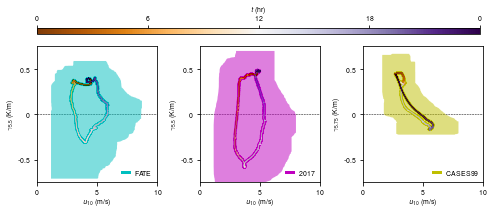

In [15]:
lw1 = 1
lw2 = 3
fs = 7

cmap = plt.cm.get_cmap('viridis')
c1 = 'y' #CASES      subplot3
c2 = 'm' #2017       subplot2
c3 = 'c' #2018, FATE subplot1

plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here

fig = plt.gcf()

###########
#CASES      subplot3

ax = plt.subplot2grid((1,3), (0, 2))

p2 = np.array([x2m, ym_f]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([p2[:-1], p2[1:]], axis=1)

lcol2 = LineCollection(segments2, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=30)
lcol2.set_array(tt_f)
lcol2.set_linewidth(lw1)

s2 = ax.add_collection(lcol2)

s = ax.plot(x2m,ym_f,c=c1,linewidth=lw2,label='CASES99',zorder=25)

s = ax.fill(xo2d, yo2d, alpha=0.5, fc=c1, ec='none',zorder=5,rasterized=True)

s = ax.plot([0,10],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.ylabel('$\\gamma_{5.75}$ (K/m)', fontsize=fs)
plt.xlabel('$u_{10}$ (m/s)', fontsize=fs)

plt.xlim([0,10])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,10,3), ('0', '5', '10'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

l = ax.legend(loc=4,frameon=False,fontsize=fs,handlelength=1)
l.set_zorder(45)

###########
#2017       subplot2

ax = plt.subplot2grid((1,3), (0, 1))

p2 = np.array([x2m_17, ym_17]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([p2[:-1], p2[1:]], axis=1)

lcol2 = LineCollection(segments2, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=30)
lcol2.set_array(tt_17)
lcol2.set_linewidth(lw1)

s2 = ax.add_collection(lcol2)

s = ax.plot(x2m_17,ym_17,c=c2,linewidth=lw2,label='2017',zorder=25)

s = ax.fill(xo2d_17, yo2d_17, alpha=0.5, fc=c2, ec='none',zorder=5,rasterized=True)

s = ax.plot([0,10],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)
plt.xlabel('$u_{10}$ (m/s)', fontsize=fs)

plt.xlim([0,10])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,10,3), ('0', '5', '10'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

l = ax.legend(loc=4,frameon=False,fontsize=fs,handlelength=1)
l.set_zorder(45)

#############
#2018, FATE subplot1

ax = plt.subplot2grid((1,3), (0, 0))

p2 = np.array([x2m_18, ym_18]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([p2[:-1], p2[1:]], axis=1)

lcol2 = LineCollection(segments2, cmap=plt.get_cmap('PuOr'),
                    norm=plt.Normalize(0, 1),zorder=30)
lcol2.set_array(tt_18)
lcol2.set_linewidth(lw1)

s2 = ax.add_collection(lcol2)

s = ax.plot(x2m_18,ym_18,c=c3,linewidth=lw2,label='FATE',zorder=25)

s = ax.fill(xo2d_18, yo2d_18, alpha=0.5, fc=c3, ec='none',zorder=5,rasterized=True)

s = ax.plot([0,10],[0,0],'--',c='k',linewidth=0.5,zorder=1)

plt.ylabel('$\\gamma_{5.5}$ (K/m)', fontsize=fs)
plt.xlabel('$u_{10}$ (m/s)', fontsize=fs)

plt.xlim([0,10])
plt.ylim([-0.75,0.75])
plt.xticks(np.linspace(0,10,3), ('0', '5', '10'))
plt.yticks(np.linspace(-0.5,0.5,3), ('-0.5', '0', '0.5'))

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

l = ax.legend(loc=4,frameon=False,fontsize=fs,handlelength=1)
l.set_zorder(45)

cbar2_ax = fig.add_axes([0.125, 0.95, 0.77, 0.03])
cbar2 = fig.colorbar(s2, ticks=[0/4,1/4,2/4,3/4,4/4], cax=cbar2_ax, orientation='horizontal')
cbar2.ax.set_xticklabels(['0', '6', '12', '18', '0'])
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.set_label('$t$ (hr)',fontsize=fs)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.tick_params(labelsize=fs)

fig.subplots_adjust(hspace=.55)
fig.subplots_adjust(wspace=.35)

fig.set_size_inches(8, 2.5, forward=True)
%cd /home/andrew/Documents/
plt.savefig('some_name86.pdf', bbox_inches='tight',dpi=300)